<a href="https://colab.research.google.com/github/mesuttguven/Denoising-Autoencoders/blob/main/8_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Auto Encoders

* Instructor: [Mesut GUVEN] (https://github.com/mesuttguven), TOBB ETU in Ankara](https://www.etu.edu.tr/en)
* For more information visit the [class website](https://github.com/mesuttguven/ML4CS).

# Video Material
This Colab consist of ***Denoising AutoEncoders in Keras*** 
https://github.com/mesuttguven/Denoising-Autoencoders

For more content please about Deep Learning and Cyber Security, visit YouTube [[Video]](https://www.youtube.com/channel/UC82XRPy1R8i5d5VxehL_Jrw/videos) 




## There are 4 hyperparameters that we need to set before training an autoencoder:

***Code size:*** number of nodes in the middle layer. Smaller size results in more compression.

***Number of layers:*** the autoencoder can be as deep as we like. The *only rule* we must follow is *Input and Output* sizes MUST be equal.

***Number of nodes per layer:*** We use a ***stacked autoencoder architecture*** *(layers are stacked one after another)*. Usually stacked autoencoders look like a “sandwitch”. 

*Here*, we create a ***symmetric model*** that have nodes per ***layer decreases with each subsequent layer of the encoder, and increases back in the decoder***. 

This architecture is not necessary and we have total control over these parameters.

***Loss function:*** we either use *mean squared error (mse)* or *binary crossentropy*. If the input values are in the *range [0, 1]* then we typically use crossentropy, otherwise we use the mean squared error. 

Autoencoders are trained the same way as ANNs via backpropagation

# Import all Necessary  Libraries





In [ ]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.3 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.6.0
    Uninstalling tensorflow-datasets-4.6.0:
      Successfully uninstalled tensorflow-datasets-4.6.0


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Loading MNIST Dataset



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


# Pre-process Data
1. Normalizing; scale to range [0-1]
2. Convert Image Matrix to a Row Vector


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


#Build a simple autoencoder model
Because there are fewer neurons, the auto-encoder must learn to encode the input to the fewer hidden neurons.

The critical components of Autoencoders are:

***Input layer*** — to pass input data into the network, 1x784 row vector.

***Hidden layer*** consisting of Encoder and Decoder — to process information by applying weights, biases and activation functions,

***Output layer*** —  matches the input neurons.


In [ ]:
from keras.layers import Dense, Input

input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

In [ ]:
from keras.models import Model
autoencoder = Model(input_img, output_img)

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 7s 2ms/step - loss: 0.1370
Epoch 2/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0985
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0928


### Plot Define

In [ ]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

# plot_autoencoder_outputs

313/313 [==============================] - 1s 2ms/step


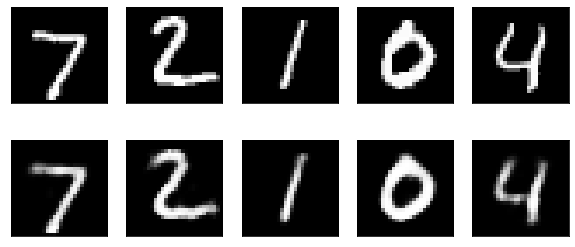

In [ ]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

# Build a sequentially symetrical autoencoder model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
autoencoder_symetrical = Sequential()
autoencoder_symetrical.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
autoencoder_symetrical.add(Dense(64, activation='relu'))
autoencoder_symetrical.add(Dense(32, activation='relu'))
autoencoder_symetrical.add(Dense(16, activation='relu'))
autoencoder_symetrical.add(Dense(32, activation='relu'))
autoencoder_symetrical.add(Dense(64, activation='relu'))
autoencoder_symetrical.add(Dense(128, activation='relu'))
autoencoder_symetrical.add(Dense(x_train.shape[1])) # Multiple output neurons

In [ ]:
autoencoder_symetrical.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 32)                544       
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dense_18 (Dense)            (None, 128)              

In [ ]:
autoencoder_symetrical.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_symetrical.fit(x_train, x_train, epochs=20)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.3460
Epoch 18/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3451
Epoch 19/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3585
Epoch 20/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3611



# plot_autoencoder_outputs

313/313 [==============================] - 1s 2ms/step


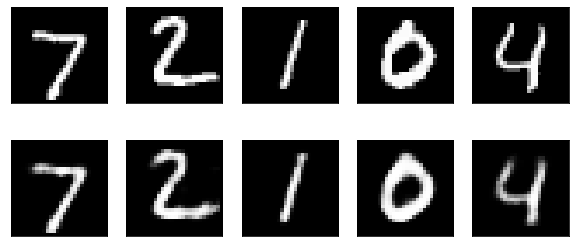

In [ ]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

# Denoising Autoencoder


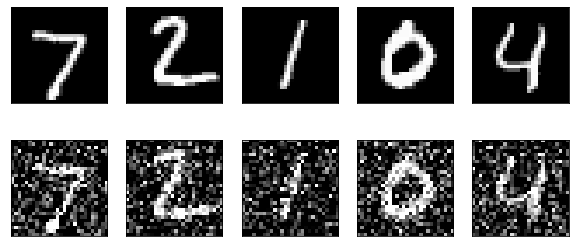

In [ ]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [ ]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1617
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1236
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1168
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1131
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1110
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1096
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1085
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1078
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1071
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1066


313/313 [==============================] - 1s 2ms/step


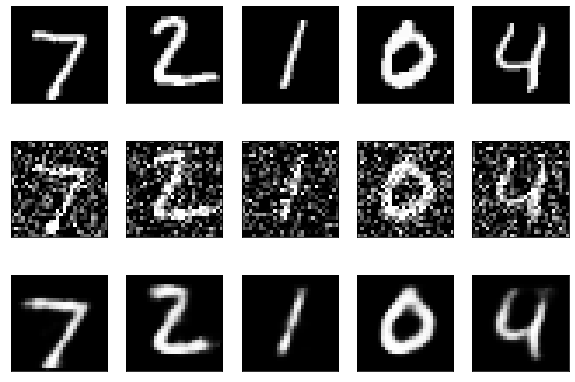

In [ ]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')